In [1]:
# === Setup ===
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# ------------------------------------------------------
# 1) Load data
# ------------------------------------------------------
csv_path = Path("../data/raw/exoplanets_2025.csv")
data = pd.read_csv(csv_path)
print("Initial shape:", data.shape)

# ------------------------------------------------------
# 2) Multi-class target
# ------------------------------------------------------
# 0 = FALSE POSITIVE, 1 = CANDIDATE, 2 = CONFIRMED
y_all_multi = np.select(
    [
        data["koi_disposition"] == "FALSE POSITIVE",
        data["koi_disposition"] == "CANDIDATE",
        data["koi_disposition"] == "CONFIRMED",
    ],
    [0, 1, 2],
    default=-1
)

# Drop rows with unknown disposition
mask = y_all_multi != -1
data = data.loc[mask]
y_all_multi = y_all_multi[mask]

print("Class distribution:")
print(pd.Series(y_all_multi).value_counts().rename({0:"False Positive",1:"Candidate",2:"Confirmed"}))

# ------------------------------------------------------
# 3) Feature set (same cleaning as before)
# ------------------------------------------------------
drop_cols = [
    "kepler_name","kepoi_name","koi_disposition","koi_pdisposition",
    "koi_tce_delivname","koi_score"   # drop score to avoid leakage
]

maybe_drop_cols = ["kepid","ra","dec","koi_kepmag"]

# Keep numeric features
X_all = data.select_dtypes(include=[np.number]).copy()

# Drop ID/constant/leaky cols if present
for c in drop_cols+maybe_drop_cols:
    if c in X_all.columns:
        X_all = X_all.drop(columns=c)

# Replace inf, drop all-NaN or constant cols
X_all = X_all.replace([np.inf,-np.inf],np.nan)
X_all = X_all.dropna(axis=1, how="all")
X_all = X_all.loc[:, X_all.nunique(dropna=True) > 1]

print("Final feature count:", X_all.shape[1])

# ------------------------------------------------------
# 4) Train/test split
# ------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all_multi, test_size=0.4, random_state=1, stratify=y_all_multi
)

print(f"[Split] Train: {X_train.shape}, Test: {X_test.shape}")

# ------------------------------------------------------
# 5) Define models
# ------------------------------------------------------
scale_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

impute_only = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
])

models_multi = {
    "Logistic Regression": Pipeline([
        ("prep", scale_pipeline),
        ("clf", LogisticRegression(max_iter=5000, class_weight="balanced", random_state=1, multi_class="multinomial"))
    ]),
    "KNN": Pipeline([
        ("prep", scale_pipeline),
        ("clf", KNeighborsClassifier(n_neighbors=5, metric="manhattan"))
    ]),
    "Decision Tree": Pipeline([
        ("prep", impute_only),
        ("clf", DecisionTreeClassifier(random_state=1, class_weight="balanced"))
    ]),
    "Random Forest": Pipeline([
        ("prep", impute_only),
        ("clf", RandomForestClassifier(n_estimators=300, random_state=1, class_weight="balanced", n_jobs=-1))
    ])
}

# ------------------------------------------------------
# 6) Train & Evaluate
# ------------------------------------------------------
results = []
for name, pipe in models_multi.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro")
    rec = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")

    results.append([name, acc, prec, rec, f1])
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, target_names=["False Positive","Candidate","Confirmed"], digits=4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Save results to a DataFrame
results_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1"])
print("\nSummary of results:")
display(results_df.sort_values("F1", ascending=False).reset_index(drop=True))


Initial shape: (8054, 153)
Class distribution:
False Positive    3965
Confirmed         2729
Candidate         1360
Name: count, dtype: int64
Final feature count: 99
[Split] Train: (4832, 99), Test: (3222, 99)

=== Logistic Regression ===
                precision    recall  f1-score   support

False Positive     0.9777    0.9937    0.9856      1586
     Candidate     0.7328    0.8015    0.7656       544
     Confirmed     0.9054    0.8416    0.8723      1092

      accuracy                         0.9097      3222
     macro avg     0.8720    0.8789    0.8745      3222
  weighted avg     0.9118    0.9097    0.9101      3222

Confusion Matrix:
 [[1576    3    7]
 [  19  436   89]
 [  17  156  919]]

=== KNN ===
                precision    recall  f1-score   support

False Positive     0.9427    0.9136    0.9280      1586
     Candidate     0.6982    0.5018    0.5840       544
     Confirmed     0.7937    0.9405    0.8609      1092

      accuracy                         0.8532      32

,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.909683,0.871953,0.878914,0.874510
1,Random Forest,0.906269,0.884674,0.843928,0.858648
2,Decision Tree,0.884233,0.841929,0.846454,0.844096
3,KNN,0.853197,0.811539,0.785311,0.790922


In [2]:
# Pick best by F1 from your results table
best_name_m = results_df.sort_values("F1", ascending=False).iloc[0]["Model"]
print("Best model:", best_name_m)

best_pipe_m = models_multi[best_name_m]
best_pipe_m.fit(X_train, y_train)

# Predictions on held-out test
y_pred_m = best_pipe_m.predict(X_test)
target_names = ["False Positive","Candidate","Confirmed"]


Best model: Logistic Regression


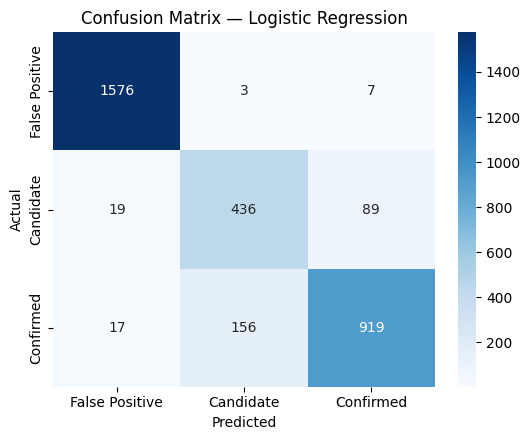

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_m, labels=[0,1,2])

plt.figure(figsize=(5.5,4.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.title(f"Confusion Matrix — {best_name_m}")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


In [4]:
from sklearn.metrics import precision_recall_fscore_support, classification_report
import pandas as pd

print(classification_report(y_test, y_pred_m, target_names=target_names, digits=4))

prec, rec, f1, sup = precision_recall_fscore_support(
    y_test, y_pred_m, labels=[0,1,2], zero_division=0
)
per_class = pd.DataFrame({
    "Class": target_names,
    "Support": sup,
    "Precision": prec,
    "Recall": rec,
    "F1": f1
})
per_class


                precision    recall  f1-score   support

False Positive     0.9777    0.9937    0.9856      1586
     Candidate     0.7328    0.8015    0.7656       544
     Confirmed     0.9054    0.8416    0.8723      1092

      accuracy                         0.9097      3222
     macro avg     0.8720    0.8789    0.8745      3222
  weighted avg     0.9118    0.9097    0.9101      3222



,Class,Support,Precision,Recall,F1
0,False Positive,1586,0.977667,0.993695,0.985616
1,Candidate,544,0.732773,0.801471,0.765584
2,Confirmed,1092,0.905419,0.841575,0.872330


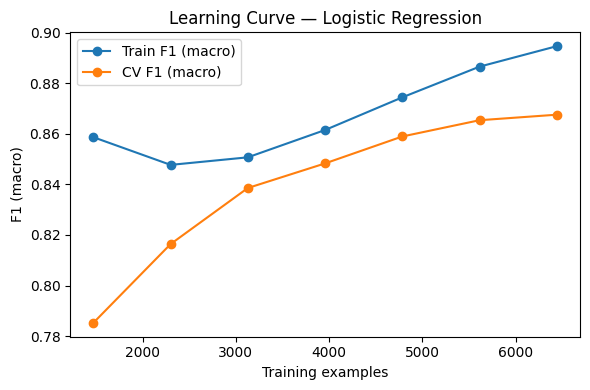

Final CV F1: 0.8676212828985486


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_pipe_m, X_all, y_all_multi,
    cv=5, scoring="f1_macro", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8)
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean, marker="o", label="Train F1 (macro)")
plt.plot(train_sizes, val_mean, marker="o", label="CV F1 (macro)")
plt.xlabel("Training examples")
plt.ylabel("F1 (macro)")
plt.title(f"Learning Curve — {best_name_m}")
plt.legend()
plt.tight_layout()
plt.show()

print("Final CV F1:", float(val_mean[-1]))


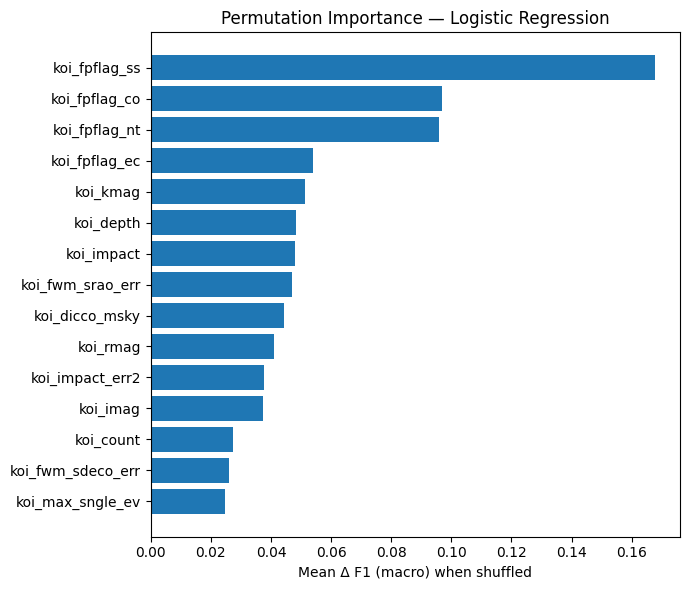

koi_fpflag_ss        0.167668
koi_fpflag_co        0.096758
koi_fpflag_nt        0.095987
koi_fpflag_ec        0.054033
koi_kmag             0.051361
koi_depth            0.048399
koi_impact           0.048103
koi_fwm_srao_err     0.046909
koi_dicco_msky       0.044296
koi_rmag             0.041145
koi_impact_err2      0.037647
koi_imag             0.037507
koi_count            0.027303
koi_fwm_sdeco_err    0.026011
koi_max_sngle_ev     0.024796
dtype: float64

In [6]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

perm = permutation_importance(
    best_pipe_m, X_test, y_test,
    scoring="f1_macro", n_repeats=10, random_state=1, n_jobs=-1
)

pi = pd.Series(perm.importances_mean, index=X_test.columns).sort_values(ascending=False)
top = pi.head(15).sort_values()  # plot smallest-to-largest for horizontal bar

plt.figure(figsize=(7,6))
plt.barh(top.index, top.values)
plt.xlabel("Mean Δ F1 (macro) when shuffled")
plt.title(f"Permutation Importance — {best_name_m}")
plt.tight_layout()
plt.show()

top[::-1]  # display top->bottom in text too


In [7]:
from sklearn.base import clone
from sklearn.model_selection import cross_val_score

# Shuffle labels; keep features the same
y_perm = pd.Series(y_all_multi).sample(frac=1.0, random_state=42).reset_index(drop=True)
X_perm = X_all.reset_index(drop=True)

scores_perm = cross_val_score(
    clone(best_pipe_m), X_perm, y_perm,
    cv=5, scoring="f1_macro", n_jobs=-1
)
print("Shuffled-label 5-fold F1 (macro):", scores_perm, 
      "Mean:", scores_perm.mean())


Shuffled-label 5-fold F1 (macro): [0.32873421 0.30481364 0.32234996 0.33405225 0.30809446] Mean: 0.3196089027610516
